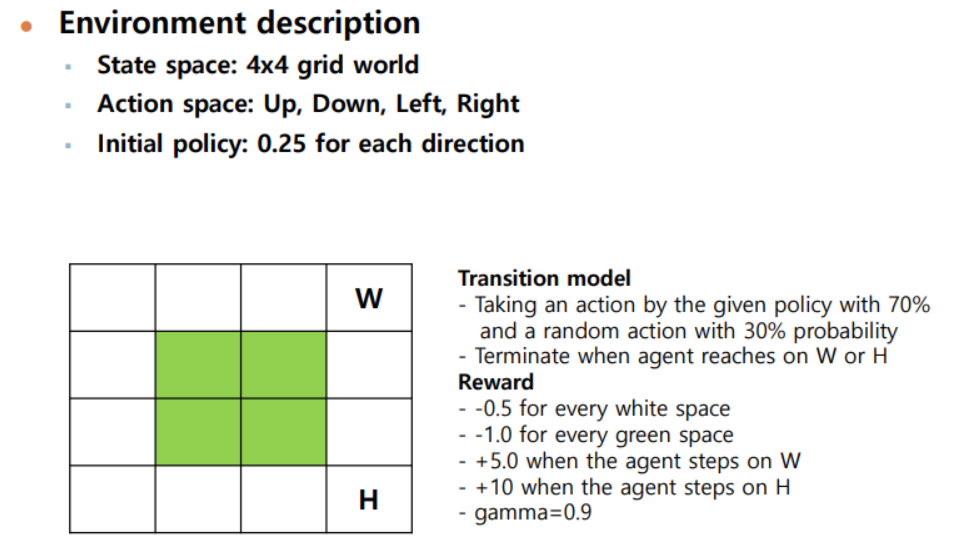

In [8]:
import numpy as np

class GridWorld():
    def __init__(self):
        self.agent_pos = {'y' : 0, 'x' : 0}
        self.home_pos = {'y' : 3, 'x' : 3}

        self.workplace_pos = {'y' : 0, 'x' : 3}
        self.park_area = {'y' : [1, 2], 'x' : [1, 2]}

        self.y_min, self.x_min, self.y_max, self.x_max = 0, 0, 3, 3

        # set up state
        self.state = self.set_state(self.agent_pos['y'], self.agent_pos['x'])

        self.state_space = []
        for y in range(4):
            for x in range(4):
                state = self.set_state(y, x)
                self.state_space.append(state)

        self.action_space = [0, 1, 2, 3] # Up, Down, Left, Right

    def set_state(self, y_agent, x_agent):
        state = np.zeros([4, 4])
        state[self.workplace_pos['y'], self.workplace_pos['x']] = 2
        state[self.home_pos['y'], self.home_pos['x']] = 3
        state[self.park_area['y'], self.park_area['x']] = -1
        state[y_agent, x_agent] = 1

        return state

    def reset(self):
        self.agent_pos = {'y' : 0, 'x' : 0}
        self.state = self.set_state(self.agent_pos['y'], self.agent_pos['x'])
        
        return self.state

    def step(self, action):
        # Update environmental variables
        is_random_action = np.random.choice([0, 1], p = [0.7, 0.3])

        if (is_random_action):
            random_action_set = list(self.action_space)
            random_action_set.remove(action)
            action = np.random.choice(random_action_set)

        if (action == 0):
            self.agent_pos['y'] = max(self.agent_pos['y'] - 1, self.y_min)
        elif (action == 1):
            self.agent_pos['y'] = min(self.agent_pos['y'] + 1, self.y_max)
        elif (action == 2):
            self.agent_pos['x'] = max(self.agent_pos['x'] - 1, self.x_min)
        elif (action == 3):
            self.agent_pos['x'] = min(self.agent_pos['x'] + 1, self.x_max)
        else:
            assert False, "Invalid action value"

        prev_state = self.state
        self.state = self.set_state(self.agent_pos['y'], self.agent_pos['x'])

        done = False
        if (self.agent_pos == self.workplace_pos) or (self.agent_pos == self.home_pos):
            done = True

        reward = self.reward(prev_state, action, self.state)

        return reward, self.state, done

    def reward(self, s, a, s_next):
        reward = -0.5
        y, x = np.where(s == 1)
        y_next, x_next = np.where(s_next == 1)

        was_at_workplace = (y == self.workplace_pos['y'] and x == self.workplace_pos['x'])
        is_at_workplace = (y_next == self.workplace_pos['y'] and x_next == self.workplace_pos['x'])

        was_at_home = (y == self.home_pos['y'] and x == self.home_pos['x'])
        is_at_home = (y_next == self.home_pos['y'] and x_next == self.home_pos['x'])

        is_in_park = (y_next in self.park_area['y'] and x_next in self.park_area['x'])

        if was_at_workplace and is_at_workplace:
            reward = 0
        elif (not was_at_workplace and is_at_workplace):
            reward = 5
        
        if (was_at_home and is_at_home):
            reward = 0
        
        if (not was_at_home and is_at_home):
            reward = 10

        if (is_in_park):
            reward = -1.0

        return reward

In [13]:
gamma = 0.95
k_alpha = 1e-3
k_eps = 5e-4

def get_state_index(state_space, state):
    for i_s, s in enumerate(state_space):
        if (s == state).all():
            return i_s

    assert False, "Couldn't find the state"

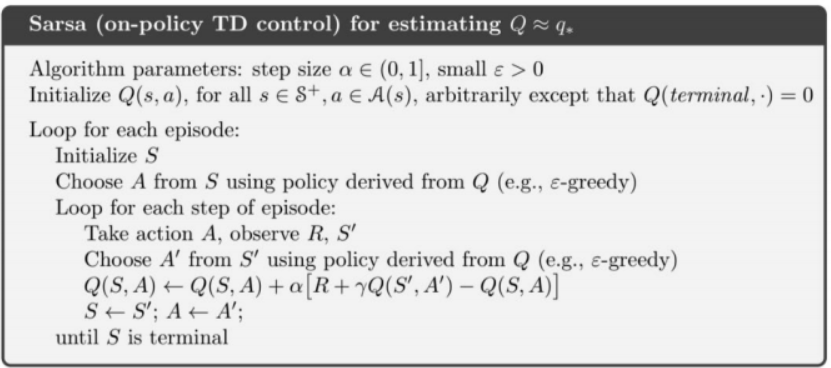

In [14]:
def sarsa(env):
    action_value_matrix = np.zeros([len(env.state_space), len(env.action_space)])

    def sample_action(eps, action_value):
        a_max = action_value.argmax()
        pi = np.zeros([len(env.action_space)])
        pi[:] = eps / len(env.action_space) # pi = [0, 0, 0, 0] -> eps=0.2 // pi = [0.05, 0.05, 0.05, 0.05]
        pi[a_max] = pi[a_max] + 1 - eps
        a = np.random.choice(env.action_space, p = pi)
        return a

    def get_eps(total_step_count):
        return 1 / (1 + k_eps * total_step_count)

    # Repeat sarsa loop
    total_step_count = 0
    for loop_count in range(10000):
        done = False
        step_count = 0

        s = env.reset()
        i_s = get_state_index(env.state_space, s)
        action_value = action_value_matrix[i_s]
        eps = get_eps(total_step_count)
        a = sample_action(eps, action_value)

        # Generate on episode
        while not done:
            r, s_next, done = env.step(a)
            i_s_next = get_state_index(env.state_space, s_next)
            action_value_next = action_value_matrix[i_s_next]
            eps = get_eps(total_step_count)
            a_next = sample_action(eps, action_value_next)

            alpha = 1 / (1 + k_alpha * loop_count)
            td = r + gamma * action_value_matrix[i_s_next][a_next] - action_value_matrix[i_s][a]
            action_value_matrix[i_s][a] = action_value_matrix[i_s][a] + alpha * td

            if done:
                action_value_matrix[i_s_next] = 0

            step_count += 1
            total_step_count += 1

            s = s_next
            i_s = i_s_next
            a = a_next
        
        if (loop_count + 1) % 100 == 0:
            print(f"[{loop_count}] action_value_matrix : \n{action_value_matrix}\n" 
            + f"eps : {get_eps(total_step_count):.4f}"
            + f"\talpha : {alpha:.4f}")

    policy = np.zeros([len(env.state_space), len(env.action_space)])
    state_indexes = np.arange(len(env.state_space))
    argmax_actions = action_value_matrix.argmax(axis = -1)
    policy[state_indexes, argmax_actions] = 1

    return action_value_matrix, policy

In [10]:
np.set_printoptions(formatter = {'float' :' {:0.3f}'.format})

env = GridWorld()
action_value_matrix, policy = sarsa(env)

argmax_actions = action_value_matrix.argmax(axis = -1)
value_vector = np.sum(policy * action_value_matrix, axis = -1)

value_table = value_vector.reshape(4, 4)
argmax_actions_table = argmax_actions.reshape(4, 4)

[99] action_value_matrix : 
[[ 0.781  -7.161  -2.899  0.016]
 [ -5.994  -8.312  -6.620  -4.605]
 [ -3.088  -3.452  -5.464  4.178]
 [ 0.000  0.000  0.000  0.000]
 [ -1.282  -7.217  -2.148  -7.300]
 [ -2.386  1.961  -7.551  -3.014]
 [ -2.932  -5.093  -2.973  -7.077]
 [ 5.002  -7.896  3.457  -4.136]
 [ -5.689  -1.272  -8.124  -7.013]
 [ -2.529  -6.143  -7.783  -0.533]
 [ 7.841  -2.323  -5.832  -0.471]
 [ 4.303  5.636  -1.937  4.255]
 [ -7.515  -0.390  -5.950  -6.406]
 [ -2.668  -5.976  -6.974  8.058]
 [ 8.964  8.845  -6.901  10.000]
 [ 0.000  0.000  0.000  0.000]]
eps : 0.4535	alpha : 0.9099
[199] action_value_matrix : 
[[ -4.659  -5.735  -4.958  -5.096]
 [ -4.378  -4.379  -5.500  3.897]
 [ 4.157  1.352  -3.140  4.969]
 [ 0.000  0.000  0.000  0.000]
 [ -4.401  -1.975  -5.296  -0.674]
 [ -0.753  -7.404  -5.130  -6.467]
 [ -1.064  -0.796  -7.021  0.432]
 [ 4.884  -3.142  -0.376  -4.559]
 [ -5.735  -5.174  -6.291  -0.612]
 [ -4.048  -1.463  -4.074  5.069]
 [ -2.758  -3.458  -0.790  -0.292]
 

In [11]:
print(f"value_table : \n{value_table}\n" + f"argmax_actions : \n{argmax_actions_table}")

value_table : 
[[ 2.793  3.448  4.660  0.000]
 [ 3.569  3.620  5.800  6.935]
 [ 4.791  5.014  7.314  8.705]
 [ 6.385  7.866  9.624  0.000]]
argmax_actions : 
[[1 3 3 0]
 [1 1 3 1]
 [1 3 3 1]
 [3 3 3 0]]


In [12]:
policy

array([[ 0.000,  1.000,  0.000,  0.000],
       [ 0.000,  0.000,  0.000,  1.000],
       [ 0.000,  0.000,  0.000,  1.000],
       [ 1.000,  0.000,  0.000,  0.000],
       [ 0.000,  1.000,  0.000,  0.000],
       [ 0.000,  1.000,  0.000,  0.000],
       [ 0.000,  0.000,  0.000,  1.000],
       [ 0.000,  1.000,  0.000,  0.000],
       [ 0.000,  1.000,  0.000,  0.000],
       [ 0.000,  0.000,  0.000,  1.000],
       [ 0.000,  0.000,  0.000,  1.000],
       [ 0.000,  1.000,  0.000,  0.000],
       [ 0.000,  0.000,  0.000,  1.000],
       [ 0.000,  0.000,  0.000,  1.000],
       [ 0.000,  0.000,  0.000,  1.000],
       [ 1.000,  0.000,  0.000,  0.000]])